# LIMITATIONS: Where weights are currently not implemented

In [1]:
#- Standardization
#- Unsupervised metrics like silhouette score
#- Factor Analysis
#- PCA

In [2]:
# Make the notebook full screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os
import pandas as pd
import importlib
import sys 

if sys.version_info[:3] < (3,4):
    os.getcdw()
    code_dir = os.path.dirname(os.getcdw())
    project_dir = os.path.dirname(os.path.dirname(os.getcdw()))
    data_path = os.path.join(code_dir, "data")
    functions_path = os.path.join(project_dir, "functions")
else: 
    from pathlib import Path
    current_directory = os.path.dirname(Path.cwd())
    code_dir = os.path.dirname(current_directory)
    project_dir = os.path.join(code_dir, "3_Unsupervised_Modeling")
    data_path = os.path.join(code_dir, "3_Unsupervised_Modeling\\data")
    functions_path = os.path.join(code_dir, 'functions')
    
#code_dir = r'D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\3_Unsupervised_Modeling\src'
project_dir = r'D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\3_Unsupervised_Modeling'
data_path = r'D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\3_Unsupervised_Modeling\data'
functions_path = r'D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\functions\functions_old'
#print(code_dir)
print(project_dir)
print(data_path)
print(functions_path)

D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\3_Unsupervised_Modeling
D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\3_Unsupervised_Modeling\data
D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\functions\functions_old


In [4]:
# General Python modules
import time
import pandas as pd
import numpy as np
import importlib

In [5]:
# Set the path for the library
import sys
sys.path.insert(0, functions_path)
import variable_reduction as vr
from solution_steps import color
from data_quality_report import dq_report
import data_processing as cpd
import dimensionality_reduction as dr
import profiling as pro
import factor_analysis
import select_model as sm
import feature_importance as fi
from load_data import load_data
import solution_steps as ss
import json
from sklearn.cluster import KMeans, DBSCAN

In [6]:
pd.set_option('display.max_columns', 100)

# Initialize the solution variables

In [7]:
with open(os.path.join(project_dir, 'data/input/Unsupervised_Modeling_Solution_Input.json')) as f:
    inputs = json.load(f)

In [8]:
inputs

{'Load_from': 'csv',
 'data_location': 'D:/BackUp - 151110/Side_Projects/Analytical_Solutions/Sotiris_Solutions/3_Unsupervised_Modeling/data/input',
 'table_name': 'fake_data.csv',
 'sample': '1.0',
 'weight_variable_name': 'None',
 'sample_variable_name': 'sample variable',
 'sample_values': ['training',
  'random validation',
  'in-time validation',
  'out-of-time validation'],
 'select_missing_variables_to_drop_threshold': 0.5,
 'character_classification_threshold': 10,
 'iqr_coef': 1.5,
 'impute_missing_imputation_strategy': 'median',
 'corr_threshold': 0.9,
 'top_n': '10',
 'number_pcs': 5,
 'number_pcs_2': 5,
 'number_factors': 4,
 'kmo_threshold': 0.5,
 'loadings_threshold': 0.8,
 'models_to_test': "[{'Model': KMeans, 'default_args': {'init': 'k-means++'}, 'test_arg': 'n_clusters', 'test_values': [2,3,4,5,6,7,8]}]",
 'final_model': "{'Model': KMeans, 'kwargs': {'n_clusters': 3, 'random_state': 2, 'init': 'k-means++'}}",
 'final_model_2': "{'Model': KMeans, 'kwargs': {'n_clusters

## Essential parameters

In [9]:
# String. Specify how to load the data. Options: csv, parq.
Load_from = inputs["Load_from"]
# String. Specify the data location: this is the folder where the data for this project are saved. 
data_location = inputs["data_location"]
# String. Set the input data file. 
table_name = inputs["table_name"]
# Float. Number between 0-1 determining what percent of data to subsample. 
sample = float(inputs["sample"])
# String. Set the weight variable name in the original dataset. If not avaulable, then provide "None".
weight_variable_name = inputs["weight_variable_name"]
# String. Set the sample column that has sample information, e.g. train/test/OOT or segment information, and will be used to split the data in different samples
# If this column does not exist, then provide "None".
sample_variable_name = inputs["sample_variable_name"]
# List of strings. Set the sub-sample values that are in the sample_variable_name field, e.f. for train/test data split and/or for different segments. 
# All samples defined in this parameters will be picked up by the solution and results will be created for these samples. 
# If sample column does not exist, then provide '[None]' (without quotes).
sample_values = inputs["sample_values"]
# List. Provide the feature names for the numeric variables that will be used for clustering. 
numeric_variables_for_clustering = inputs["numeric_variables_clustering"]
# List. Provide the feature names for the character variables that will be used for clustering. 
character_variables_for_clustering = inputs["character_variables_clustering"]
# List. Provide the feature names for the numeric variables that will be used for profiling/overlaying. 
numeric_variables_for_profiling = inputs["numeric_variables_profiling"]
# List. Provide the feature names for the character variables that will be used for profiling/overlaying. 
character_variables_for_profiling = inputs["character_variables_profiling"]
# Int. Used in factor_analysis.remove_features function. Determines the number of factors to be used in Factor Analysis. 
number_factors = inputs["number_factors"]
# Int. Used in dimensionality_reduction.fit_transform. Determines the number of principal components to be used in the final PCA model. 
number_pcs = inputs["number_pcs"]
# Int. Used in dimensionality_reduction.fit_transform. Determines the number of principal components to be used in the final PCA model during the second iteration, after dropping features with low feautre importnance. 
number_pcs_2 = inputs["number_pcs_2"]
# List. Models to test. Must include the model function, fedault arguments, the test argument name, and a list of values to test. 
models_to_test = eval(inputs["models_to_test"])
# Dictionary. Includes the model function and arguments for the final model to be used in clustering. 
final_model = eval(inputs["final_model"])
# Dictionary. Includes the model function and arguments for the final model to be used in clustering, after features were dropped due to low feature importance. 
final_model_2 = eval(inputs["final_model_2"])

## Advanced parameters

In [10]:
# Float. Takes values between 0 and 1. Used in 'select_missing_variables_to_drop' function. Variables with percentage missing values above this threshold will be 
# dropped from the rest of the process. 
select_missing_variables_to_drop_threshold = inputs["select_missing_variables_to_drop_threshold"]
# Integer. Used in 'character_classification' function. Character variables with more levels than this threshold will be dropped from the rest of the process. 
character_classification_threshold = inputs["character_classification_threshold"]
# Float. Used in the 'replace_outliers' function in the outlier removal section. This is the coefficient for Interquantile range. 
# It can be used to adjust how many outliers to replace; the higher the value the less outliers are replaced. 
iqr_coef = inputs["iqr_coef"]
# String. Used in 'impute_missing' class. Select the stratefy to impute the missing values. Current options are "median", "mean", 
# or a specific value without quotes, e.g. 0.
impute_missing_imputation_strategy = inputs["impute_missing_imputation_strategy"]
# Float. Used in 'corr_eliminator' function in the initial correlations calculations. Variables with correlation greater than this threshold will be dropped. 
corr_threshold = inputs["corr_threshold"]
# Int. Used in the 'corr_eliminator' function in the initial correlations calculations. After highly correlated features are dropped, this is the number of the next highest correlations. 
top_n = eval(inputs["top_n"])
# Float. Used in factor_analysis.setup function. Variables with KMO above this threshold will be tested in Factor Analysis. 
kmo_threshold = inputs["kmo_threshold"]
# Float. Used in factor_analysis.remove features function. Variables with factor loadings above this threshold will be dropped. 
loadings_threshold = inputs["loadings_threshold"]
# Float. Used in FeatureImportance.feature_importance_keep_vars. Variables that have feature importance less than this threshold will be dropped from clustering. 
feature_importance_threshold = inputs["feature_importance_threshold"]

# Load the data

In [11]:
data_full = load_data(method = Load_from, 
                     data_path = data_location, 
                     table_name = table_name, 
                     sample = sample)

load_data took 0.06 seconds


In [12]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   random_var_0     10000 non-null  float64
 1   random_var_1     10000 non-null  float64
 2   random_var_2     10000 non-null  float64
 3   random_var_3     10000 non-null  float64
 4   random_var_4     10000 non-null  float64
 5   random_var_5     10000 non-null  float64
 6   random_var_6     10000 non-null  float64
 7   random_var_7     10000 non-null  float64
 8   random_var_8     10000 non-null  float64
 9   random_var_9     10000 non-null  float64
 10  random_var_10    10000 non-null  float64
 11  random_var_11    10000 non-null  float64
 12  random_var_12    10000 non-null  float64
 13  random_var_13    10000 non-null  float64
 14  random_var_14    10000 non-null  float64
 15  random_var_15    10000 non-null  float64
 16  random_var_16    10000 non-null  float64
 17  random_var_17

In [13]:
data_full.head()

,random_var_0,random_var_1,random_var_2,random_var_3,random_var_4,random_var_5,random_var_6,random_var_7,random_var_8,random_var_9,random_var_10,random_var_11,random_var_12,random_var_13,random_var_14,random_var_15,random_var_16,random_var_17,random_var_18,random_var_19,cat_3,cat_5,cat_20,cat_200,num_2%,num_20%,num_90%,num_99%,outlier_1,outlier_2,weight_variable,sample variable,target,amount
0,-2.120469,1.828175,-1.218833,2.200348,1.023035,0.103858,0.002735,1.862627,0.147227,-1.253023,-0.311479,-0.192586,-1.707226,1.917344,-0.544900,0.151839,0.861162,0.303319,1.637773,-1.408925,2,NaN,10.0,190,10.417022,76.549700,NaN,NaN,-1000.0,-100000.0,0.188589,training,0,0.000000
1,-0.069143,-2.849152,-1.926399,0.179987,1.747270,-1.828218,0.925883,-1.125307,-1.317622,0.616703,-1.043918,-2.162899,-0.921324,-1.448640,1.241900,-5.155156,-10.394122,1.070378,0.434384,-1.028799,1,NaN,17.0,50,10.720325,30.817276,NaN,NaN,-1000.0,-100000.0,0.720316,training,1,11814.396081
2,-0.511473,1.112241,0.638801,2.860112,0.601878,1.114607,-2.250368,-2.491429,4.289313,2.473633,-3.609535,2.144912,-0.863763,-0.009340,0.669498,-0.352783,4.572632,0.754917,1.654304,-1.619198,1,NaN,18.0,99,10.000114,73.537790,NaN,NaN,-1000.0,-100000.0,0.925076,training,0,0.000000
3,-0.019528,-1.043367,-0.650218,3.563748,-1.011323,-4.322013,-1.377731,-0.146822,-3.666339,0.493248,-0.928599,-3.044790,0.274440,-2.349754,1.237911,3.290751,-4.730226,0.498014,0.052220,-2.219356,2,NaN,18.0,68,10.302333,NaN,NaN,NaN,-1000.0,-100000.0,0.419611,training,0,0.000000
4,0.885574,-0.943430,-0.359084,-1.266709,-1.439655,4.028367,0.312653,0.078573,3.323244,1.120039,-0.409986,-1.026792,1.437958,2.364782,-0.275218,-0.277629,4.212077,-0.637334,1.066726,4.081518,2,NaN,2.0,141,10.146756,23.669432,NaN,NaN,-1000.0,-100000.0,0.078632,random validation,0,0.000000


# Create the Weight and Sample variables, if not available in the input dataset

In [14]:
# Create the weight variable
data_full, weight_variable_name_solution = ss.weight_var_assignment(data_full = data_full, 
                                                                 weight_variable_name = weight_variable_name)

# Create the sample variable
data_full, sample_values_solution, sample_variable_name_solution = ss.sample_var_assignment(data_full = data_full, 
                                                                                         sample_variable_name = sample_variable_name, 
                                                                                           sample_values = sample_values)

weight_var_assignment took 0.0 seconds
sample_var_assignment took 0.0 seconds


# Convert variable data types based on user information

In [15]:
# Convert character variables for clustering
data_full, character_variables_list_clustering = ss.convert_character_var(data_full = data_full, 
                                                        original_candidate_variables_character = character_variables_for_clustering,
                                                        sample_variable_name_solution = sample_variable_name_solution)
data_full, character_variables_list_profiling = ss.convert_character_var(data_full = data_full, 
                                                        original_candidate_variables_character = character_variables_for_profiling,
                                                        sample_variable_name_solution = sample_variable_name_solution)
character_variables_list = list(set(character_variables_list_clustering + character_variables_list_profiling))

# Convert numeric variables for clustering
data_full, numeric_variables_list_clustering = ss.convert_numeric_var(data_full = data_full, 
                                                        original_candidate_variables_numeric = numeric_variables_for_clustering,
                                                        weight_variable_name_solution = weight_variable_name_solution, 
                                                        target_variable_name = '')
data_full, numeric_variables_list_profiling = ss.convert_numeric_var(data_full = data_full, 
                                                        original_candidate_variables_numeric = numeric_variables_for_profiling,
                                                        weight_variable_name_solution = weight_variable_name_solution, 
                                                        target_variable_name = '')
numeric_variables_list = list(set(numeric_variables_list_clustering + numeric_variables_list_profiling))


Character variables: ['cat_3', 'cat_5', 'cat_20', 'cat_200', 'sample variable']
convert_character_var took 0.03 seconds

Character variables: ['cat_3', 'cat_5', 'cat_20', 'cat_200', 'sample variable']
convert_character_var took 0.01 seconds

Numeric variables: ['random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'random_var_15', 'random_var_16', 'random_var_17', 'random_var_18', 'random_var_19', 'num_2%', 'num_20%', 'num_90%', 'num_99%', 'outlier_1', 'outlier_2', 'weight_variable_solution']
convert_numeric_var took 0.01 seconds

Numeric variables: ['random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'rando

# Data quality report

In [16]:
dq = dq_report(df = data_full, 
                data_path = data_path, 
                variables = character_variables_list + numeric_variables_list, 
                weight_variable = weight_variable_name_solution, 
                dq_report_file = 'data_quality_report.csv')

,Variable Name,Missing Value Percentage,Min,Max,Mean,Median,Unique Values
1,cat_5,99.10,NaN,NaN,NaN,NaN,5
17,num_99%,99.07,62.670483,9882.135000,4648.040822,4283.611300,93
21,num_90%,89.91,5.453561,997.980600,508.553644,526.509800,1009
15,num_20%,20.40,0.018950,99.990010,50.380773,50.799396,7958
0,cat_20,9.99,NaN,NaN,NaN,NaN,20
12,num_2%,1.93,10.000097,10.999876,10.497596,10.500104,9745
4,cat_200,0.00,NaN,NaN,NaN,NaN,200
5,random_var_15,0.00,-9.764426,10.229585,0.588335,0.729931,10000
7,random_var_11,0.00,-7.743272,6.915500,-0.776566,-0.779030,9998
6,random_var_3,0.00,-7.550564,9.626160,0.019184,-0.132409,9999


Data quality report took 0.31s. to run


# Split sample data

In [17]:
data, sample_values_dict = ss.split_sample_data(
    data_full=data_full, 
    sample_values_solution=sample_values_solution, 
    sample_variable_name_solution=sample_variable_name_solution
    )

Sample data dictionary: {'training': 'SAMPLE 0', 'random validation': 'SAMPLE 1', 'in-time validation': 'SAMPLE 2', 'out-of-time validation': 'SAMPLE 3'}

SAMPLE 0
The shape is:  (5977, 35)
Creating this sample took 0.00s. to run
SAMPLE 1
The shape is:  (1987, 35)
Creating this sample took 0.00s. to run
SAMPLE 2
The shape is:  (985, 35)
Creating this sample took 0.00s. to run
SAMPLE 3
The shape is:  (1051, 35)
Creating this sample took 0.00s. to run
split_sample_data took 0.01 seconds


# Set the original candidate variables

In [18]:
original_variables_clustering = character_variables_for_clustering + numeric_variables_for_clustering
print(color.BLUE + 'Original variables for clustering: ' + color.END + str(original_variables_clustering))
original_variables_profiling = character_variables_for_profiling + numeric_variables_for_profiling
print(color.BLUE + 'Original variables for profiling: ' + color.END + str(original_variables_profiling))

Original variables for clustering: ['cat_3', 'cat_5', 'cat_20', 'cat_200', 'random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'random_var_15', 'random_var_16', 'random_var_17', 'random_var_18', 'random_var_19', 'num_2%', 'num_20%', 'num_90%', 'num_99%', 'outlier_1', 'outlier_2']
Original variables for profiling: ['cat_3', 'cat_5', 'cat_20', 'cat_200', 'random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'random_var_15', 'random_var_16', 'random_var_17', 'random_var_18', 'random_var_19', 'num_2%', 'num_20%', 'num_90%', 'num_99%', 'outlier_1', 'outlier_2']


# Remove variables with high missing values percentage

In [19]:
# Variables excluded from the non-predictive features: keys, target, sample, etc
excluded_variables = [x for x in data['data_{}'.format(sample_values_solution[0])].columns if x not in original_variables_clustering]
print(color.BLUE + 'Variables to be excluded: ' + color.END + str(excluded_variables))
print()
# Produce and save the missing values table to review
missing_variables_table, missing_variables = ss.missing_values_vars(
    sample_values_dict=sample_values_dict, 
    data_path=data_path, 
    data=data, 
    weight_variable_name_solution=weight_variable_name_solution, 
    select_missing_variables_to_drop_threshold=select_missing_variables_to_drop_threshold
    )
# Create the variables to remove: non-predictors + variables with too many missing information
excluded_variables = excluded_variables + missing_variables
print(color.BLUE + 'Variables to remove from the remainder of the analysis: ' + color.END + str(excluded_variables))

Variables to be excluded: ['weight_variable', 'sample variable', 'target', 'amount', 'weight_variable_solution']

SAMPLE 0
Creating the missing variables table took 0.05s. to run

SAMPLE 1
Creating the missing variables table took 0.03s. to run

SAMPLE 2
Creating the missing variables table took 0.03s. to run

SAMPLE 3
Creating the missing variables table took 0.03s. to run

Variables with too many missing values: ['cat_5', 'num_90%', 'num_99%']

missing_values_vars took 0.15 seconds
Variables to remove from the remainder of the analysis: ['weight_variable', 'sample variable', 'target', 'amount', 'weight_variable_solution', 'cat_5', 'num_90%', 'num_99%']


# Remove character variables with many levels

In [20]:
keep_char_vars_levels = ss.character_var_levels(
    data = data, 
    data_path = data_path, 
    sample_values_solution = sample_values_solution,
    excluded_variables = excluded_variables, 
    character_classification_threshold = character_classification_threshold
    )

Keep character variables['cat_3', 'cat_20', 'cat_200']

Category variables in 3 classes: 
single []
binary []
small ['cat_3']
large ['cat_20', 'cat_200']

Character variables kept: ['cat_3']

character_var_levels took 0.01 seconds


# Outlier replacement for numeric variables

In [21]:
outlier_variables = [i for i in numeric_variables_list if i not in excluded_variables]
data_full = cpd.replace_outliers(
    input_data = data_full, 
    variables = outlier_variables, 
    weight_variable = weight_variable_name_solution, 
    data_path = data_path, 
    outlier_info_file = 'outlier_info.csv', 
    iqr_coef = iqr_coef
    )

,variable,%_below_lower_limit,%_above_upper_limit,Lower limit,Upper limit
0,num_2%,0.00%,0.00%,8.54%,12.46%
0,num_20%,0.00%,0.00%,-145.92%,245.81%
0,outlier_1,0.20%,0.20%,3.54%,7.46%
0,outlier_2,0.20%,0.20%,-734.11%,1234.59%
0,random_var_0,0.00%,0.00%,-9.43%,9.37%
0,random_var_1,0.00%,0.00%,-17.62%,15.63%
0,random_var_10,0.00%,0.00%,-19.51%,19.85%
0,random_var_11,0.00%,0.00%,-18.94%,17.66%
0,random_var_12,0.00%,0.00%,-9.28%,9.32%
0,random_var_13,0.00%,0.00%,-19.29%,21.11%


replace_outliers took 0.11 seconds


In [22]:
# Split sample data
data = {}
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)
    
    data['data_{}'.format(i)] = data_full[data_full[sample_variable_name_solution]==i]
    print('The shape is: ', data['data_{}'.format(i)].shape)
    
    print('This code took %.2fs. to run'%(time.time() - start_time))

SAMPLE 0
The shape is:  (5977, 35)
This code took 0.00s. to run
SAMPLE 1
The shape is:  (1987, 35)
This code took 0.00s. to run
SAMPLE 2
The shape is:  (985, 35)
This code took 0.00s. to run
SAMPLE 3
The shape is:  (1051, 35)
This code took 0.00s. to run


# Convert categorical variables to binary variables

In [23]:
cpd.character_to_binary(
    input_data = data_full, 
    input_variable_list = keep_char_vars_levels, 
    drop = 'last', # Specifies which value to drop from the one hot encoder. None will return binary variables for all categories. 'first' will drop the most populated category. 'last' will drop the less populated category. 
    protected_class_valid_values = None # Specifies accepted values for the protected class column. For non-protected class conversions use 'None'
    )

In [24]:
# Split sample data
data = {}
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)
    
    data['data_{}'.format(i)] = data_full[data_full[sample_variable_name_solution]==i]
    print('The shape is: ', data['data_{}'.format(i)].shape)
    
    print('This code took %.2fs. to run'%(time.time() - start_time))

SAMPLE 0
The shape is:  (5977, 37)
This code took 0.01s. to run
SAMPLE 1
The shape is:  (1987, 37)
This code took 0.00s. to run
SAMPLE 2
The shape is:  (985, 37)
This code took 0.00s. to run
SAMPLE 3
The shape is:  (1051, 37)
This code took 0.00s. to run


In [25]:
# Keep all numeric variables, including those that were one-hot encoded
keep_num_vars = cpd.identify_numeric_variables(input_data=data['data_{}'.format(sample_values_solution[0])])
keep_num_vars = [x for x in keep_num_vars if x not in excluded_variables]
print('Keeping the following variables: ', keep_num_vars)
print(len(keep_num_vars))

Keeping the following variables:  ['random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'random_var_15', 'random_var_16', 'random_var_17', 'random_var_18', 'random_var_19', 'num_2%', 'num_20%', 'outlier_1', 'outlier_2', 'cat_3_3', 'cat_3_2']
26


# Impute missing values

In [26]:
variables_with_missing_dict = {}
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)
    
    variables_with_missing_dict['variables_with_missing_dict_{}'.format(i)] = cpd.select_missing_variables_to_drop(
    data_path = data_path, 
    sample_name = j, 
    threshold = 0
    )
    
    print('This code took %.2fs. to run'%(time.time() - start_time))

SAMPLE 0
This code took 0.00s. to run
SAMPLE 1
This code took 0.00s. to run
SAMPLE 2
This code took 0.00s. to run
SAMPLE 3
This code took 0.00s. to run


In [27]:
# Select numeric features with missing values. Imputation will be applied to only these features, in order to improve the performance of the code. 
variables_with_missing = list(dict.fromkeys(sum(variables_with_missing_dict.values(), [])))
num_variables_with_missing = [i for i in keep_num_vars if i in variables_with_missing]
num_variables_with_missing

['num_2%', 'num_20%']

In [28]:
# Impute missing values
start_time = time.time()
impute_missing = cpd.impute_missing(
        variables = num_variables_with_missing, 
        imputation_strategy = impute_missing_imputation_strategy)
impute_missing.imputation_fit_weight(
        input_data = data['data_{}'.format(sample_values_solution[0])], 
        weight_variable = weight_variable_name_solution)

for i, j in sample_values_dict.items():
    impute_missing.imputation_transform(input_data = data['data_{}'.format(i)])

print('This code took %.2fs. to run'%(time.time() - start_time))

This code took 0.01s. to run


In [29]:
# Check missing values for imputed variables
for i, j in sample_values_dict.items():
    start_time = time.time()
    print(color.BOLD + color.PURPLE + color.UNDERLINE + j + color.END)

    if num_variables_with_missing != []:
        print(data['data_{}'.format(i)][num_variables_with_missing].apply
              (lambda x: (sum(data['data_{}'.format(i)][x.isnull()][weight_variable_name_solution])
                /sum(data['data_{}'.format(i)][weight_variable_name_solution])) * 100, axis=0).sort_values(ascending=False))
    else: 
        print('There are no variables with missing values to impute')

    print('This code took %.2fs. to run'%(time.time() - start_time))

SAMPLE 0
num_2%     0.0
num_20%    0.0
dtype: float64
This code took 0.01s. to run
SAMPLE 1
num_2%     0.0
num_20%    0.0
dtype: float64
This code took 0.00s. to run
SAMPLE 2
num_2%     0.0
num_20%    0.0
dtype: float64
This code took 0.00s. to run
SAMPLE 3
num_2%     0.0
num_20%    0.0
dtype: float64
This code took 0.00s. to run


# Drop numeric variables with only one value

In [30]:
keep_num_vars_one_v = ss.keep_num_variables_one_value(
    keep_num_vars = keep_num_vars, 
    data_path = data_path, 
    dq_report = 'data_quality_report.csv'
    )

['random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'random_var_15', 'random_var_16', 'random_var_17', 'random_var_18', 'random_var_19', 'num_2%', 'num_20%', 'outlier_1', 'outlier_2', 'cat_3_3', 'cat_3_2']
26
keep_num_variables_one_value took 0.0 seconds


# Select features for clustering

In [31]:
keep_one_hot_list = []
for i in character_variables_for_clustering:
    keep_one_hot_list = keep_one_hot_list + [col for col in keep_num_vars_one_v if col.startswith(i)]
keep_numeric_vars_list = [x for x in original_variables_clustering if x in keep_num_vars_one_v]
keep_vars_for_clustering = keep_numeric_vars_list + keep_one_hot_list
print(keep_vars_for_clustering)
print(len(keep_vars_for_clustering))

['random_var_0', 'random_var_1', 'random_var_2', 'random_var_3', 'random_var_4', 'random_var_5', 'random_var_6', 'random_var_7', 'random_var_8', 'random_var_9', 'random_var_10', 'random_var_11', 'random_var_12', 'random_var_13', 'random_var_14', 'random_var_15', 'random_var_16', 'random_var_17', 'random_var_18', 'random_var_19', 'num_2%', 'num_20%', 'outlier_1', 'outlier_2', 'cat_3_3', 'cat_3_2']
26


# Remove highly correlated features

In [32]:
corrs = vr.calculate_correlations(
    train_df = data['data_{}'.format(sample_values_solution[0])], 
    features = keep_vars_for_clustering, 
    corr_threshold = corr_threshold, 
    weight_variable_name = weight_variable_name_solution
    )

The following columns have a correlation above your threshold


,feature_1,feature_2,correlation


calculate_correlations took 0.65 seconds


In [33]:
eliminated, remaining_predictors = vr.correlation_elimination(
    method = 'correlation', 
    features = keep_vars_for_clustering, 
    train_df = data['data_{}'.format(sample_values_solution[0])], 
    data_path = data_path, 
    corr_threshold = corr_threshold, 
    top_n = top_n, 
    weight_variable_name = weight_variable_name_solution, 
    correlations = corrs
    )


Variables eliminated from correlation: []
Number of variables eliminated from correlation: 0
Keeping the following variables (Correlation < 0.9): ['random_var_15', 'random_var_14', 'random_var_3', 'random_var_7', 'random_var_1', 'random_var_11', 'random_var_2', 'outlier_1', 'random_var_19', 'random_var_4', 'random_var_0', 'outlier_2', 'random_var_6', 'num_2%', 'random_var_9', 'cat_3_2', 'random_var_16', 'random_var_8', 'cat_3_3', 'num_20%', 'random_var_10', 'random_var_17', 'random_var_5', 'random_var_18', 'random_var_13', 'random_var_12']
Number of variables kept from correlation: 26
Here are the top 10 features with the highest correlations after removing highly correlated features


,feature_1,feature_2,correlation
0,random_var_19,random_var_7,0.595467
1,random_var_13,random_var_7,0.562636
2,cat_3_2,cat_3_3,-0.512368
3,random_var_16,random_var_8,0.508695
4,random_var_16,random_var_1,0.473815
5,random_var_19,random_var_11,-0.450663
6,random_var_8,random_var_7,-0.450381
7,random_var_10,random_var_3,-0.418585
8,random_var_9,random_var_3,0.379679
9,random_var_7,random_var_6,0.365399


correlation_elimination took 0.02 seconds


# Standardize the data

In [34]:
data_standardized = cpd.standardize_data(
    input_data = data, 
    variables = remaining_predictors, 
    training_sample = 'data_{}'.format(sample_values_solution[0]), 
    data_path = data_path, 
    filename = 'standard_scaler.pkl'
    )

standardize_data took 0.03 seconds


# Remove features using Factor Analysis

Results of Bartlett's test of sphericity:
	Chi squared value : 416625.44087505643
	p value : 0.0

Results of Kaiser-Meyer-Olkin (KMO) test:
Overall KMO = 0.521

Selecting adequate variables and recomputing KMO
	Overall KMO = 0.480
	Variables with KMO >= 0.5 = ['random_var_14', 'random_var_3', 'random_var_7', 'random_var_2', 'outlier_1', 'random_var_0', 'outlier_2', 'num_2%', 'random_var_9', 'random_var_16', 'random_var_8', 'random_var_10', 'random_var_17']
	# of variables with KMO >= 0.5 = 13
	Variables with KMO < 0.5 = ['random_var_15', 'random_var_1', 'random_var_11', 'random_var_19', 'random_var_4', 'random_var_6', 'cat_3_2', 'cat_3_3', 'num_20%', 'random_var_5', 'random_var_18', 'random_var_13', 'random_var_12']
	# of variables with KMO < 0.5 = 13



C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


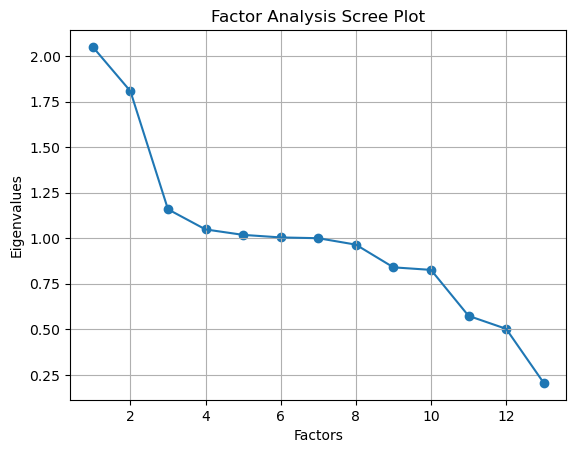

setup took 0.43 seconds


In [35]:
fa = factor_analysis.FactorAnalysis(
        data = data_standardized, 
        training_sample = 'data_{}'.format(sample_values_solution[0]), 
        datapath = data_path, 
        filename = 'FactorAnalysis'
    )
fa.setup(kmo_threshold = kmo_threshold)

In [36]:
data_standardized = fa.remove_features(
        n_factors = number_factors, 
        loadings_threshold = loadings_threshold
    )

Factor loadings table


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,0,1,2,3
random_var_14,0.004256,0.000156,-0.012180,0.021379
random_var_3,0.252998,0.649791,-0.061117,0.058090
random_var_7,-0.480457,-0.011237,-0.103700,0.018856
random_var_2,0.002880,-0.016733,0.000722,0.005153
outlier_1,-0.117766,0.043294,-0.008968,0.790026
random_var_0,-0.027590,0.000483,0.010338,0.005101
outlier_2,-0.028844,-0.015732,-0.007061,0.205821
num_2%,0.002962,-0.000385,0.011500,0.018130
random_var_9,0.063805,0.517231,-0.160699,0.044175
random_var_16,0.365064,-0.876981,-0.328873,-0.055307


Features with high loadings


{0: ['random_var_8'], 1: ['random_var_16'], 2: [], 3: []}

Features dropped: []
Remaining features: ['random_var_15', 'random_var_14', 'random_var_3', 'random_var_7', 'random_var_1', 'random_var_11', 'random_var_2', 'outlier_1', 'random_var_19', 'random_var_4', 'random_var_0', 'outlier_2', 'random_var_6', 'num_2%', 'random_var_9', 'cat_3_2', 'random_var_16', 'random_var_8', 'cat_3_3', 'num_20%', 'random_var_10', 'random_var_17', 'random_var_5', 'random_var_18', 'random_var_13', 'random_var_12']
Number of remaining features: 26
remove_features took 0.1 seconds


# PCA transformation

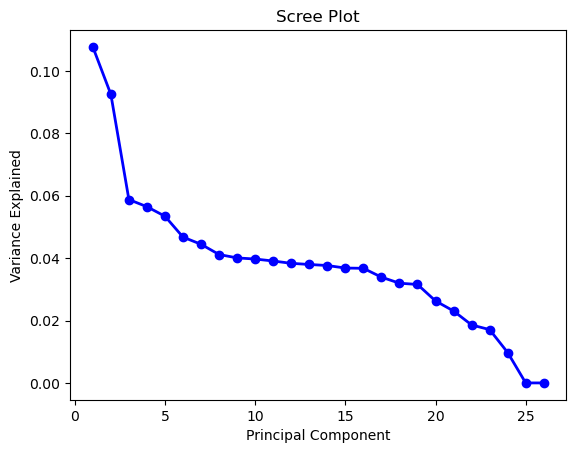

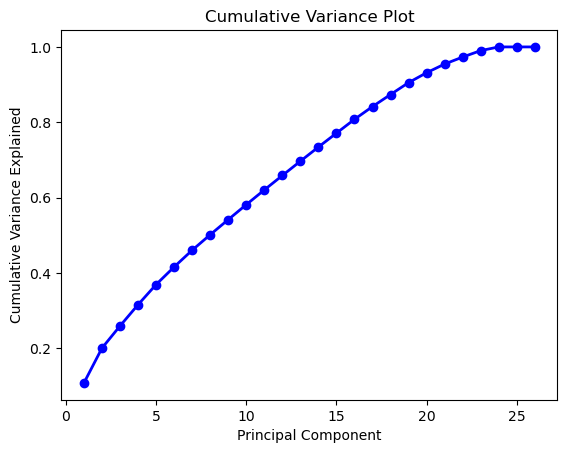

Variance explained by each principal component:
 [1.07724103e-01 9.25211530e-02 5.87842689e-02 5.64957841e-02
 5.34414608e-02 4.67515573e-02 4.44473435e-02 4.11689512e-02
 4.00811955e-02 3.97210125e-02 3.90866112e-02 3.83454896e-02
 3.79747762e-02 3.76421031e-02 3.68311368e-02 3.67461314e-02
 3.39140491e-02 3.19717896e-02 3.15690358e-02 2.62855087e-02
 2.30651437e-02 1.85904277e-02 1.70891428e-02 9.75182505e-03
 4.21263619e-17 4.03322314e-17]
Cumulative sum of variance explained by each principal component:
 [0.1077241  0.20024526 0.25902952 0.31552531 0.36896677 0.41571833
 0.46016567 0.50133462 0.54141582 0.58113683 0.62022344 0.65856893
 0.69654371 0.73418581 0.77101695 0.80776308 0.84167713 0.87364892
 0.90521795 0.93150346 0.9545686  0.97315903 0.99024817 1.
 1.         1.        ]
explore took 0.4 seconds


PCA(n_components=26, svd_solver='full')

In [37]:
dimension_reduction = dr.dimension_reduction(dic_of_dfs = data_standardized, 
        data_path = data_path, 
        training_sample = 'data_{}'.format(sample_values_solution[0])
        )
dimension_reduction.explore()

In [38]:
pca_data = dimension_reduction.fit_transform(pca_components = number_pcs, 
        solver = 'full', 
        filename = 'pca_model.pkl'
        )

In [39]:
pca_data['data_{}'.format(sample_values_solution[0])].head()

,0,1,2,3,4
0,-0.223875,0.378220,-1.981761,1.652915,-0.845690
1,-1.530021,-2.898215,-0.865336,0.142402,-1.692529
2,-3.002861,1.439843,-0.269204,2.483201,-1.415579
3,-1.441332,-2.142039,-2.957878,-1.258559,-1.668153
4,-2.422072,-1.634468,-0.554483,0.845748,0.014656


# Clustering methodology

## Select the best parameters

In [40]:
sm_object = sm.SelectModel(df = pca_data,
        sample_values_solution = sample_values_solution, 
        weights = data['data_{}'.format(sample_values_solution[0])][weight_variable_name_solution], 
        data_path = data_path, 
        filename = 'ClusterProfile_'
        )

In [41]:
for m in models_to_test:
    sm_object.set_test_model(m)
    display(sm_object.get_profile(bootstraps = 10, 
        sample_size = 0.1
        ))

C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 2 took 1.03s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 3 took 0.75s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 4 took 0.8s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 5 took 0.77s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 6 took 0.76s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 7 took 0.78s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 8 took 0.79s. to run
get_profile took 5.67 seconds


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,n_clusters,Silhouette score,Calinski Harabasz score,Davies Bouldin score,Adjusted Rand Index score,WCSS,Stability score
0,2,0.18,1420.95,1.94,0.52,46322.18,0.92
1,3,0.17,1341.06,1.69,0.74,39571.94,0.96
2,4,0.16,1145.98,1.74,0.49,36391.80,0.40
3,5,0.15,1058.58,1.66,0.51,33550.24,0.45
4,6,0.15,987.89,1.61,0.45,31379.70,0.43
5,7,0.15,933.32,1.59,0.43,29586.22,0.36
6,8,0.15,889.83,1.55,0.43,28058.47,0.39


# Develop the Clustering model

In [42]:
model = sm_object.create_model(model_inputs = final_model, filename='model.pkl')

create_model took 0.01 seconds


# Test the Clustering model on validation data

In [43]:
sm_object.validate_data()

validate_data took 0.72 seconds


,Split,Sample Size,Silhouette score,Scaled Calinski Harabasz score,Davies Bouldin score,Scaled WCSS,Cluster 1 Size,Cluster 2 Size,Cluster 3 Size
0,training,5977.0,0.175,0.224,1.689,6.621,0.262,0.367,0.371
1,random validation,1987.0,0.176,0.223,1.669,6.655,0.259,0.362,0.378
2,in-time validation,985.0,0.178,0.231,1.682,6.492,0.265,0.365,0.370
3,out-of-time validation,1051.0,0.164,0.220,1.733,6.489,0.285,0.354,0.361


# Feature contribution to clusters

In [44]:
character_variables_dropped = [x for x in character_variables_for_clustering if x not in keep_char_vars_levels]
numeric_variables_dropped = [x for x in numeric_variables_for_clustering if x not in keep_vars_for_clustering]
non_feature_imp = character_variables_dropped + numeric_variables_dropped + [sample_variable_name_solution, weight_variable_name_solution]
variables_list_profiling = [col for col in numeric_variables_list_profiling + character_variables_list_profiling if col not in non_feature_imp]

In [45]:
fi_object = fi.FeatureImportance(X = data['data_{}'.format(sample_values_solution[0])][variables_list_profiling], 
        labels = model.labels_, 
        weights = data['data_{}'.format(sample_values_solution[0])][weight_variable_name_solution], 
        data_path = data_path, 
        filename = 'FeatureImportance'
    )

In [46]:
imps = fi_object.get_report()
imps

get_report took 7.29 seconds


,0,1,2,overall_feature_importance
Feature,,,,
random_var_7,0.011417,0.058382,0.089901,0.159700
random_var_16,0.061358,0.012453,0.042789,0.116600
random_var_19,0.005552,0.055727,0.034263,0.095542
random_var_9,0.034314,0.035848,0.009861,0.080024
random_var_11,0.006035,0.022905,0.048748,0.077688
random_var_3,0.026719,0.037634,0.012509,0.076862
random_var_10,0.021659,0.039895,0.012009,0.073564
random_var_15,0.019078,0.015582,0.008258,0.042919
random_var_6,0.007351,0.019740,0.010120,0.037211


# Keep features based on Feature Importance

In [47]:
keep_fi_vars = fi_object.feature_importance_keep_vars(
        feature_importance_threshold = feature_importance_threshold
        )
keep_fi_vars = [x for x in remaining_predictors if x in keep_fi_vars]
print(keep_fi_vars)
print(len(keep_fi_vars))

feature_importance_keep_vars took 0.0 seconds
['random_var_15', 'random_var_14', 'random_var_3', 'random_var_7', 'random_var_1', 'random_var_11', 'random_var_2', 'outlier_1', 'random_var_19', 'random_var_4', 'random_var_0', 'outlier_2', 'random_var_6', 'num_2%', 'random_var_9', 'cat_3_2', 'random_var_16', 'random_var_8', 'cat_3_3', 'num_20%', 'random_var_10', 'random_var_17', 'random_var_5', 'random_var_18', 'random_var_13', 'random_var_12']
26


# Standardize the data

### The steps below are optional, but recommended since there is an opportunity to remove the least important features from clustering as they add noise to the clusters. 

In [48]:
data_standardized = cpd.standardize_data(
    input_data = data, 
    variables = keep_fi_vars, 
    training_sample = 'data_{}'.format(sample_values_solution[0]), 
    data_path = data_path, 
    filename = 'standard_scaler_2.pkl'
    )    

standardize_data took 0.02 seconds


# PCA transformation

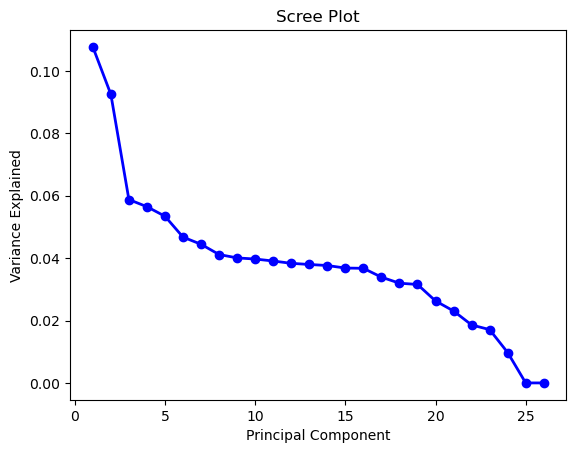

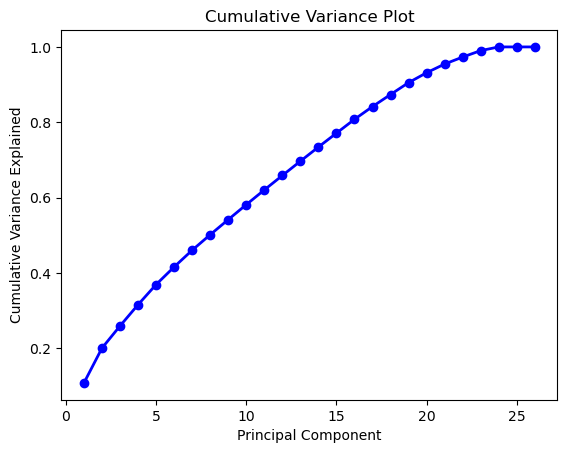

Variance explained by each principal component:
 [1.07724103e-01 9.25211530e-02 5.87842689e-02 5.64957841e-02
 5.34414608e-02 4.67515573e-02 4.44473435e-02 4.11689512e-02
 4.00811955e-02 3.97210125e-02 3.90866112e-02 3.83454896e-02
 3.79747762e-02 3.76421031e-02 3.68311368e-02 3.67461314e-02
 3.39140491e-02 3.19717896e-02 3.15690358e-02 2.62855087e-02
 2.30651437e-02 1.85904277e-02 1.70891428e-02 9.75182505e-03
 4.21263619e-17 4.03322314e-17]
Cumulative sum of variance explained by each principal component:
 [0.1077241  0.20024526 0.25902952 0.31552531 0.36896677 0.41571833
 0.46016567 0.50133462 0.54141582 0.58113683 0.62022344 0.65856893
 0.69654371 0.73418581 0.77101695 0.80776308 0.84167713 0.87364892
 0.90521795 0.93150346 0.9545686  0.97315903 0.99024817 1.
 1.         1.        ]
explore took 0.39 seconds


PCA(n_components=26, svd_solver='full')

In [49]:
dimension_reduction = dr.dimension_reduction(dic_of_dfs = data_standardized, 
        data_path = data_path, 
        training_sample = 'data_{}'.format(sample_values_solution[0])
        )
dimension_reduction.explore()

In [50]:
pca_data = dimension_reduction.fit_transform(pca_components = min(number_pcs_2, data_standardized['data_{}'.format(sample_values_solution[0])].shape[1]), 
        solver = 'full', 
        filename = 'pca_model_2.pkl'
        )

In [51]:
pca_data['data_{}'.format(sample_values_solution[0])].head()

,0,1,2,3,4
0,-0.223875,0.378220,-1.981761,1.652915,-0.845690
1,-1.530021,-2.898215,-0.865336,0.142402,-1.692529
2,-3.002861,1.439843,-0.269204,2.483201,-1.415579
3,-1.441332,-2.142039,-2.957878,-1.258559,-1.668153
4,-2.422072,-1.634468,-0.554483,0.845748,0.014656


# Clustering methodology

## Select the best parameters

In [52]:
sm_object = sm.SelectModel(df = pca_data,
        sample_values_solution = sample_values_solution, 
        weights = data['data_{}'.format(sample_values_solution[0])][weight_variable_name_solution], 
        data_path = data_path, 
        filename = 'ClusterProfile_2_'
        )

In [53]:
for m in models_to_test:
    sm_object.set_test_model(m)
    display(sm_object.get_profile(bootstraps = 10, 
        sample_size = 0.1
        ))

C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 2 took 0.76s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 3 took 0.76s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 4 took 0.81s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 5 took 0.8s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 6 took 0.77s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 7 took 0.77s. to run


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\creep\miniconda3\envs\Unsupervised_Modeling

Cluster profiling for 8 took 0.78s. to run
get_profile took 5.46 seconds


C:\Users\creep\miniconda3\envs\Unsupervised_Modeling\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


,n_clusters,Silhouette score,Calinski Harabasz score,Davies Bouldin score,Adjusted Rand Index score,WCSS,Stability score
0,2,0.18,1418.29,1.94,0.45,46338.89,0.56
1,3,0.17,1340.98,1.69,0.44,39572.75,0.69
2,4,0.16,1182.69,1.72,0.54,35971.14,0.75
3,5,0.15,1061.50,1.64,0.41,33511.88,0.49
4,6,0.15,999.02,1.60,0.41,31220.47,0.46
5,7,0.15,937.10,1.58,0.43,29528.32,0.51
6,8,0.15,886.99,1.55,0.47,28104.41,0.37


# Develop the Clustering model

In [54]:
model = sm_object.create_model(model_inputs = final_model_2, filename='model_2.pkl')

create_model took 0.01 seconds


# Test the Clustering model on validation data

In [55]:
sm_object.validate_data()

validate_data took 0.71 seconds


,Split,Sample Size,Silhouette score,Scaled Calinski Harabasz score,Davies Bouldin score,Scaled WCSS,Cluster 1 Size,Cluster 2 Size,Cluster 3 Size
0,training,5977.0,0.175,0.224,1.689,6.621,0.262,0.367,0.371
1,random validation,1987.0,0.176,0.223,1.669,6.655,0.259,0.362,0.378
2,in-time validation,985.0,0.178,0.231,1.682,6.492,0.265,0.365,0.370
3,out-of-time validation,1051.0,0.164,0.220,1.733,6.489,0.285,0.354,0.361


# Feature contribution to clusters


In [56]:
fi_object = fi.FeatureImportance(X = data['data_{}'.format(sample_values_solution[0])][variables_list_profiling], 
        labels = model.labels_, 
        weights = data['data_{}'.format(sample_values_solution[0])][weight_variable_name_solution], 
        data_path = data_path, 
        filename = 'FeatureImportance_2'
    )

In [57]:
imps = fi_object.get_report()
imps

get_report took 7.62 seconds


,0,1,2,overall_feature_importance
Feature,,,,
random_var_7,0.011417,0.058382,0.089901,0.159700
random_var_16,0.061358,0.012453,0.042789,0.116600
random_var_19,0.005552,0.055727,0.034263,0.095542
random_var_9,0.034314,0.035848,0.009861,0.080024
random_var_11,0.006035,0.022905,0.048748,0.077688
random_var_3,0.026719,0.037634,0.012509,0.076862
random_var_10,0.021659,0.039895,0.012009,0.073564
random_var_15,0.019078,0.015582,0.008258,0.042919
random_var_6,0.007351,0.019740,0.010120,0.037211


# Profiling

In [58]:
# Add cluster labels to the input data
data_cluster = data['data_{}'.format(sample_values_solution[0])]
data_cluster.loc[:, 'cluster_labels'] = model.labels_
data_cluster.head()

C:\Users\creep\AppData\Local\Temp\ipykernel_135644\409156493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster.loc[:, 'cluster_labels'] = model.labels_


,random_var_0,random_var_1,random_var_2,random_var_3,random_var_4,random_var_5,random_var_6,random_var_7,random_var_8,random_var_9,random_var_10,random_var_11,random_var_12,random_var_13,random_var_14,random_var_15,random_var_16,random_var_17,random_var_18,random_var_19,cat_3,cat_5,cat_20,cat_200,num_2%,num_20%,num_90%,num_99%,outlier_1,outlier_2,weight_variable,sample variable,target,amount,weight_variable_solution,cat_3_3,cat_3_2,cluster_labels
0,-2.120469,1.828175,-1.218833,2.200348,1.023035,0.103858,0.002735,1.862627,0.147227,-1.253023,-0.311479,-0.192586,-1.707226,1.917344,-0.544900,0.151839,0.861162,0.303319,1.637773,-1.408925,2,NaN,10.0,190,10.417022,76.549700,NaN,NaN,3.536788,-734.107629,0.188589,training,0,0.000000,1.0,0,1,1
1,-0.069143,-2.849152,-1.926399,0.179987,1.747270,-1.828218,0.925883,-1.125307,-1.317622,0.616703,-1.043918,-2.162899,-0.921324,-1.448640,1.241900,-5.155156,-10.394122,1.070378,0.434384,-1.028799,1,NaN,17.0,50,10.720325,30.817276,NaN,NaN,3.536788,-734.107629,0.720316,training,1,11814.396081,1.0,0,0,1
2,-0.511473,1.112241,0.638801,2.860112,0.601878,1.114607,-2.250368,-2.491429,4.289313,2.473633,-3.609535,2.144912,-0.863763,-0.009340,0.669498,-0.352783,4.572632,0.754917,1.654304,-1.619198,1,NaN,18.0,99,10.000114,73.537790,NaN,NaN,3.536788,-734.107629,0.925076,training,0,0.000000,1.0,0,0,1
3,-0.019528,-1.043367,-0.650218,3.563748,-1.011323,-4.322013,-1.377731,-0.146822,-3.666339,0.493248,-0.928599,-3.044790,0.274440,-2.349754,1.237911,3.290751,-4.730226,0.498014,0.052220,-2.219356,2,NaN,18.0,68,10.302333,51.055861,NaN,NaN,3.536788,-734.107629,0.419611,training,0,0.000000,1.0,0,1,1
5,0.241482,-2.279198,0.106523,1.476776,1.374350,1.896778,1.542940,-2.474195,-0.386851,2.841056,-1.416807,0.198564,0.648596,-0.853981,-0.209426,-2.298899,-7.266509,-0.146580,0.742064,-2.266463,1,NaN,NaN,186,10.092339,6.282373,NaN,NaN,3.536788,-734.107629,0.876610,training,1,6715.564317,1.0,0,0,1


## Profile categorical attributes

D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\functions\functions_old\profiling.py:150: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  t1 = pd.DataFrame(weighted_frequency_group(table_name, var, weight_variable_name, cluster_variable_name, normalize=True).sort_index()).T.stack().reset_index().rename(columns={'level_1': 'labels'})
D:\BackUp - 151110\Side_Projects\Analytical_Solutions\Sotiris_Solutions\functions\functions_old\profiling.py:150: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  t1 = pd.DataFrame(weighted_frequency_group(table_name, var,

,Attribute,labels,0,1,2,Baseline,0_baseline_diff,1_baseline_diff,2_baseline_diff
0,cat_3,1,32.91%,32.54%,31.47%,32.24%,2.07%,0.94%,-2.39%
1,cat_3,2,30.36%,33.32%,35.75%,33.44%,-9.23%,-0.38%,6.90%
2,cat_3,3,36.73%,34.14%,32.78%,34.31%,7.05%,-0.51%,-4.48%
0,cat_5,NaN,0.06%,0.27%,0.14%,0.17%,-61.88%,63.68%,-19.16%
1,cat_5,1.0,0.19%,0.18%,0.41%,0.27%,-28.53%,-31.80%,51.58%
...,...,...,...,...,...,...,...,...,...
195,cat_200,95,0.32%,0.55%,0.59%,0.50%,-36.47%,9.12%,16.77%
196,cat_200,96,0.45%,0.68%,0.41%,0.52%,-13.93%,32.00%,-21.76%
197,cat_200,97,0.64%,0.32%,0.41%,0.44%,46.61%,-26.55%,-6.72%
198,cat_200,98,0.89%,0.46%,0.54%,0.60%,48.24%,-24.22%,-10.17%


character_summary_statistics took 1.84 seconds


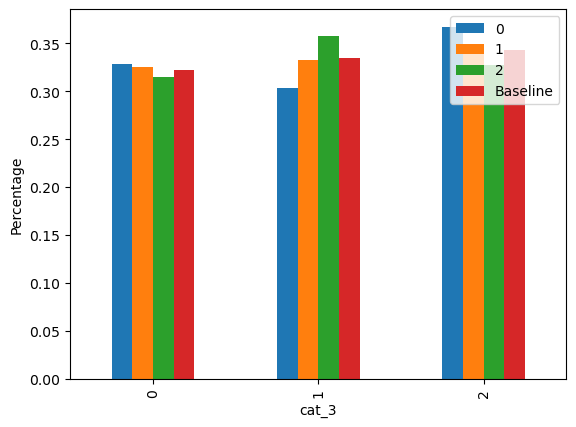

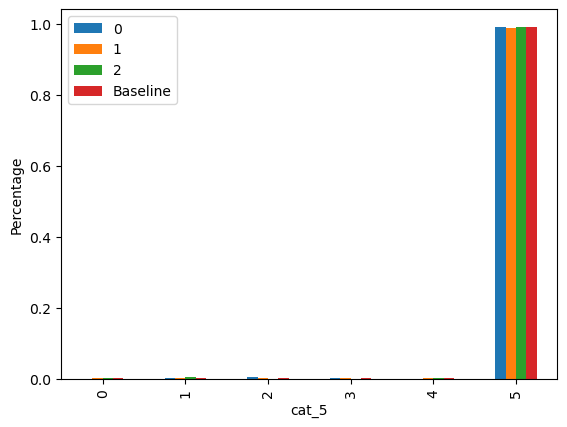

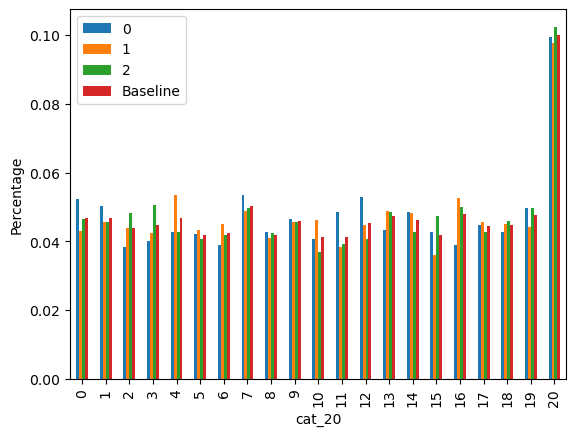

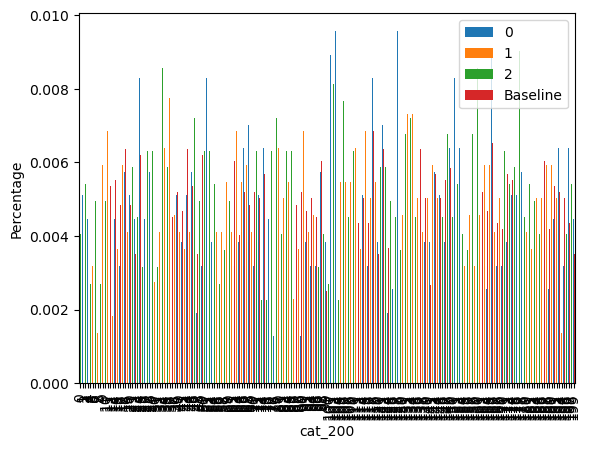

In [59]:
pro.character_summary_statistics(
    table_name = data_cluster, 
    variable_list = [x for x in character_variables_list_profiling if x not in [sample_variable_name_solution]], 
    cluster_variable_name = 'cluster_labels', 
    weight_variable_name = weight_variable_name_solution,
    data_path = data_path
    )

## Profile numeric attributes

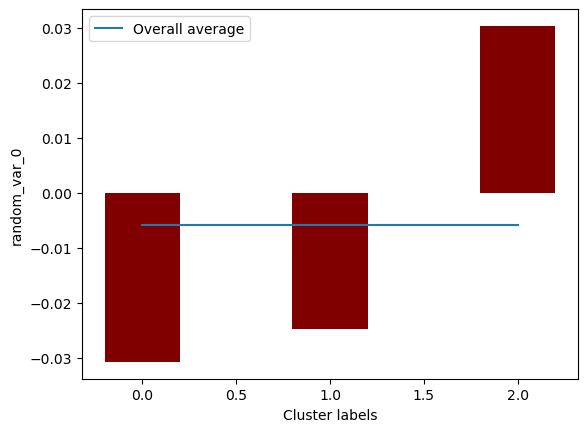

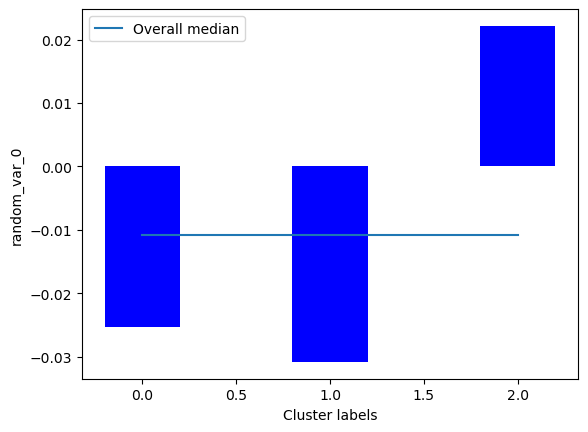

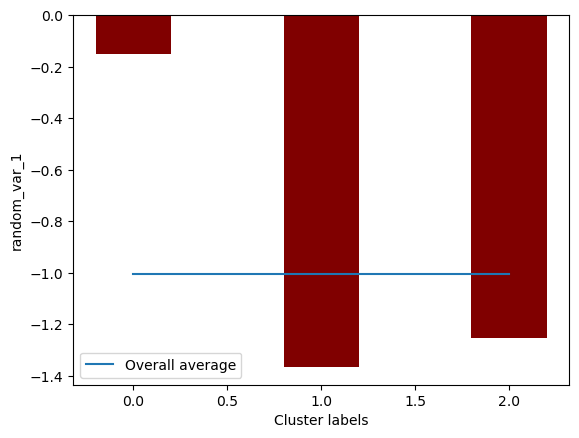

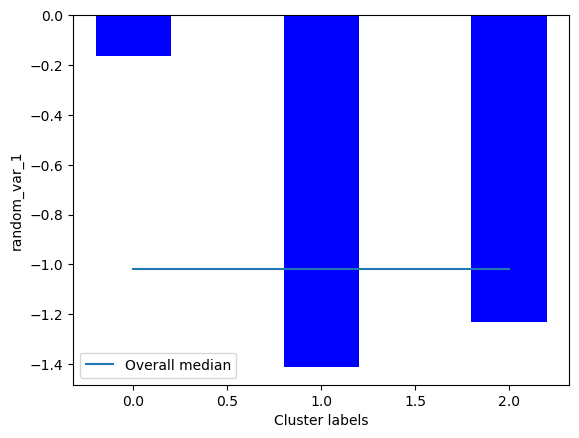

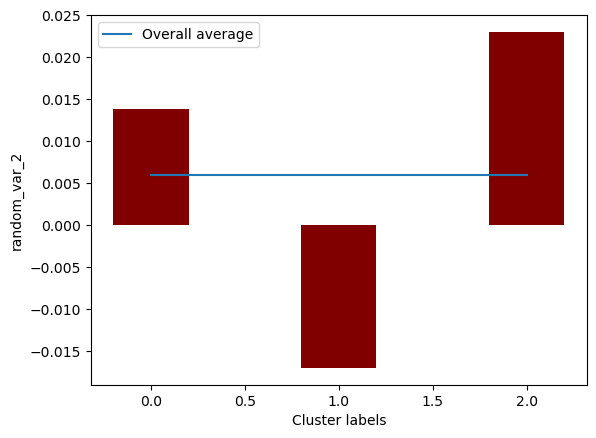

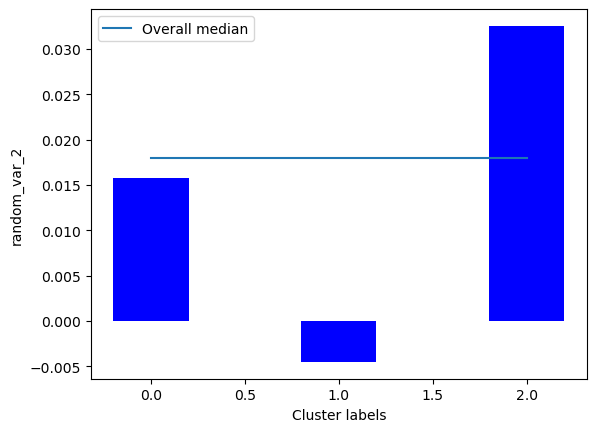

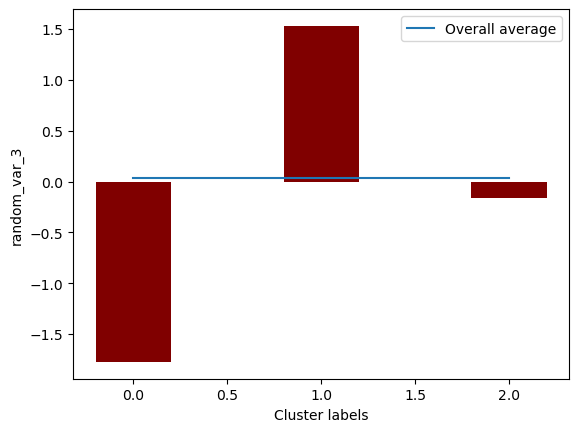

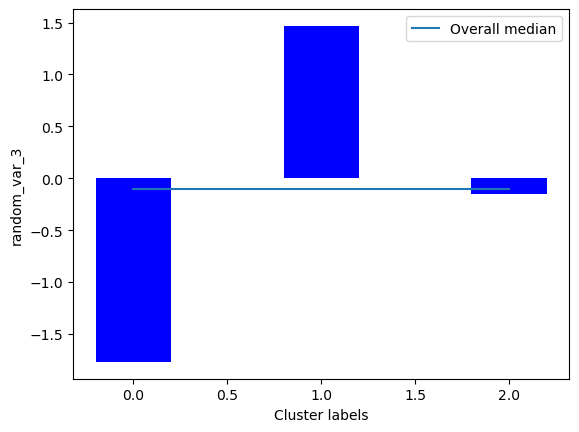

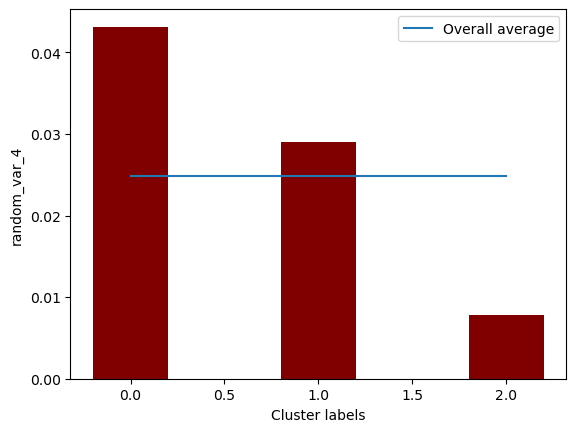

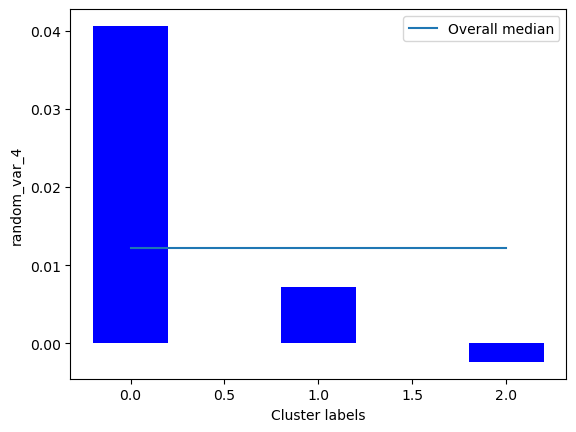

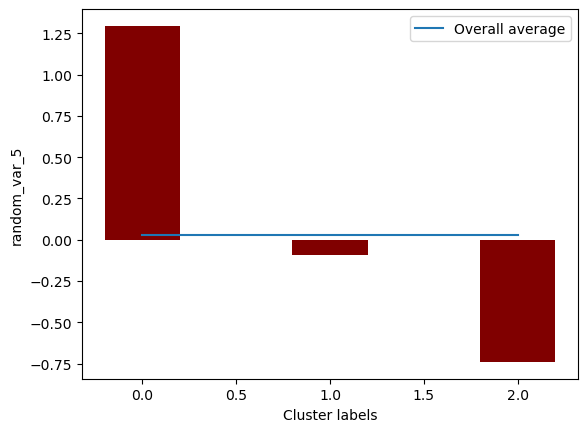

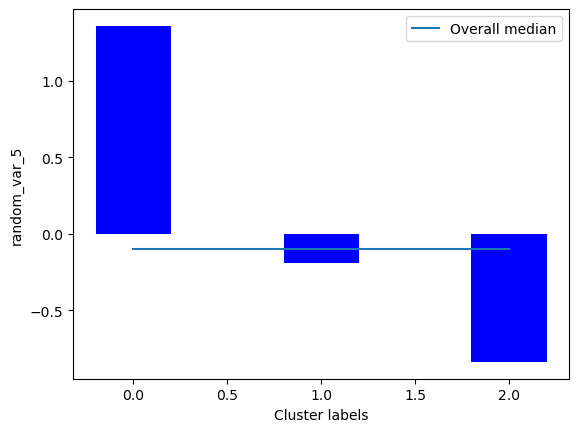

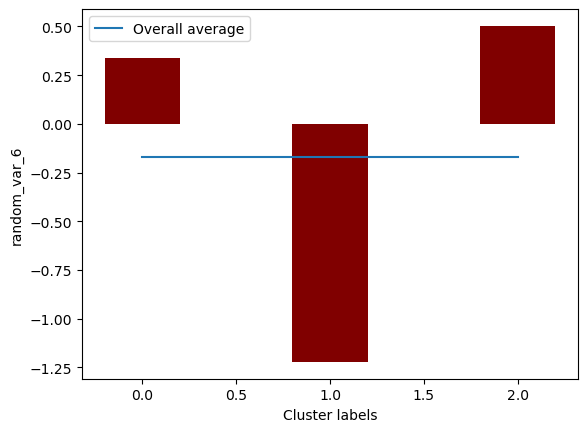

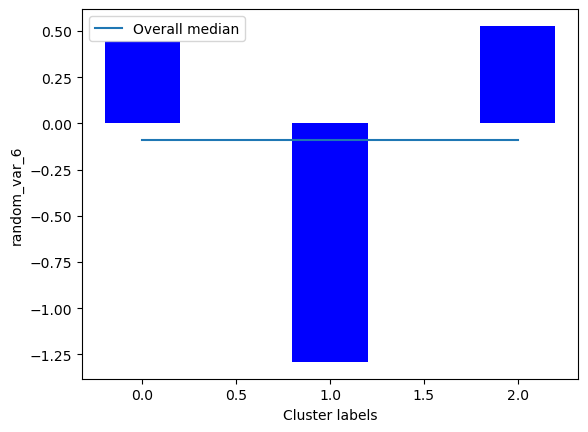

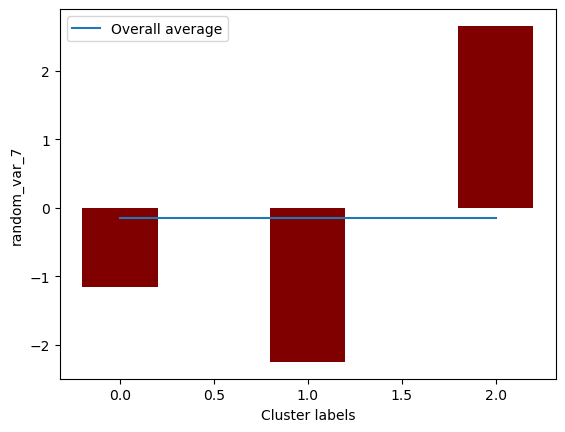

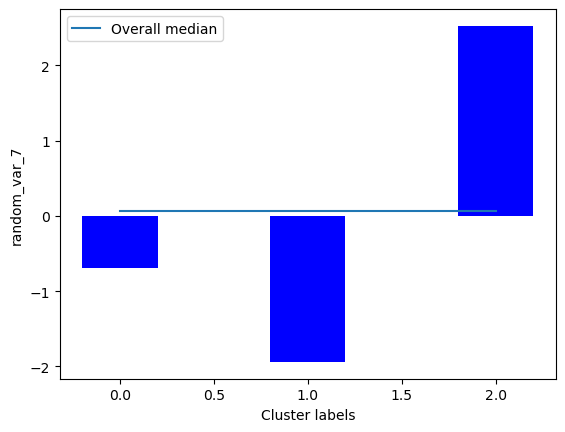

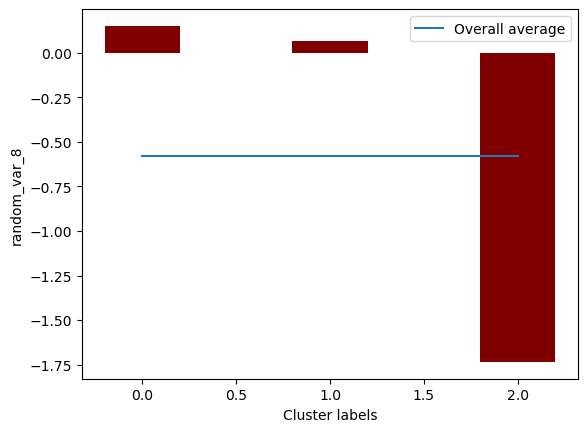

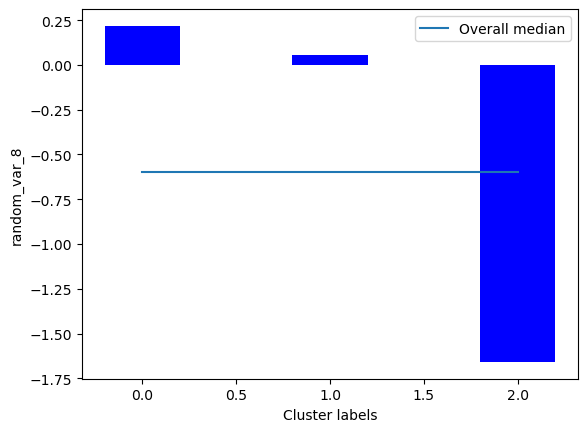

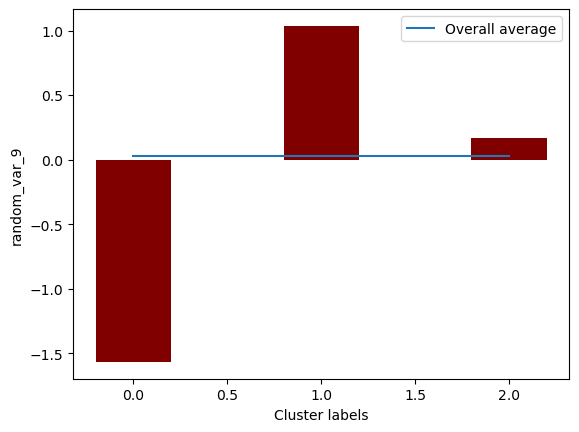

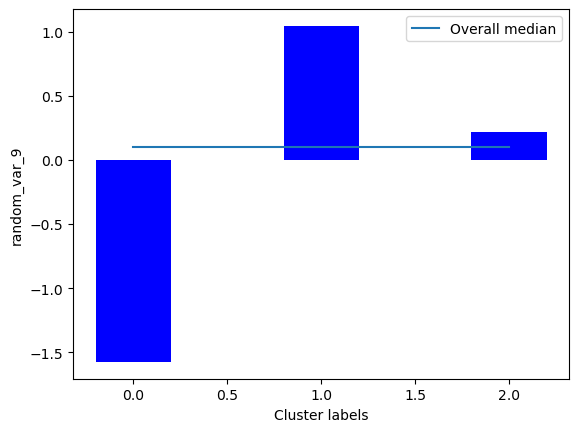

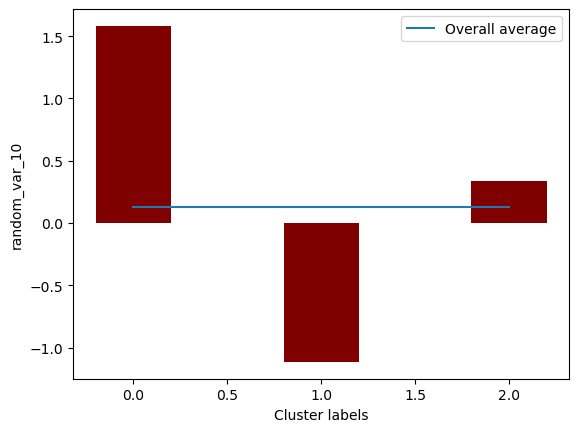

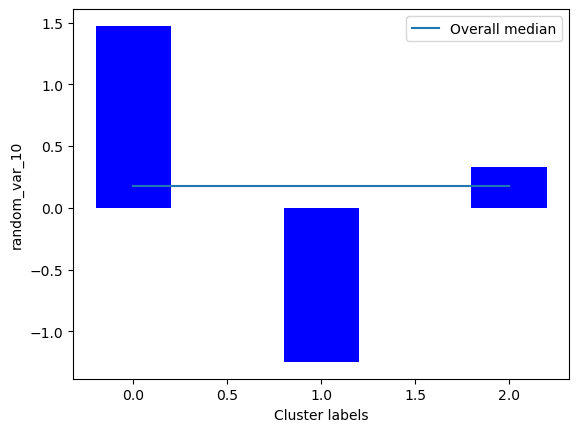

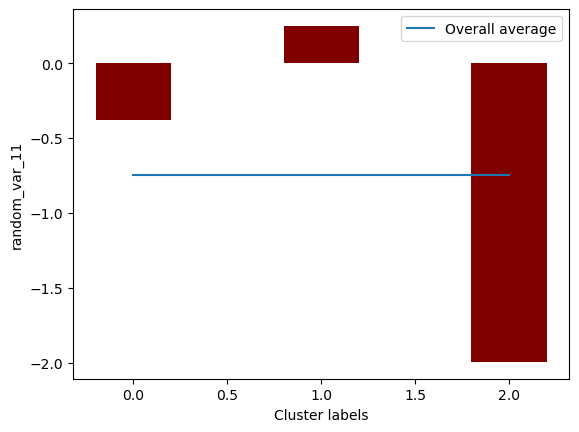

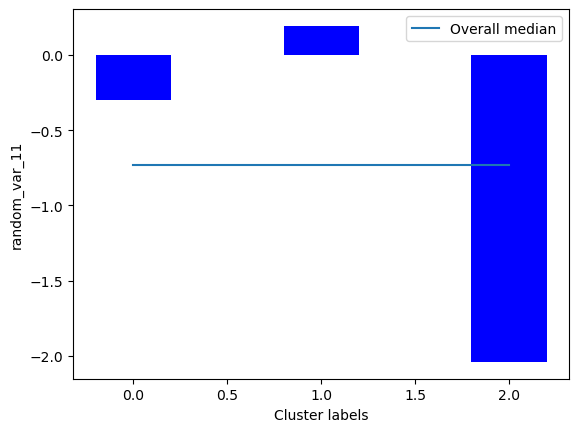

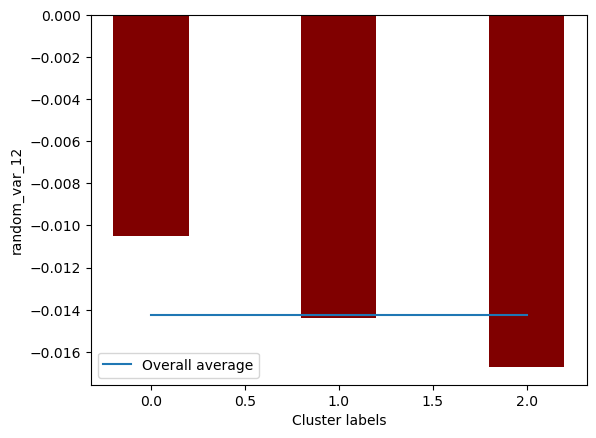

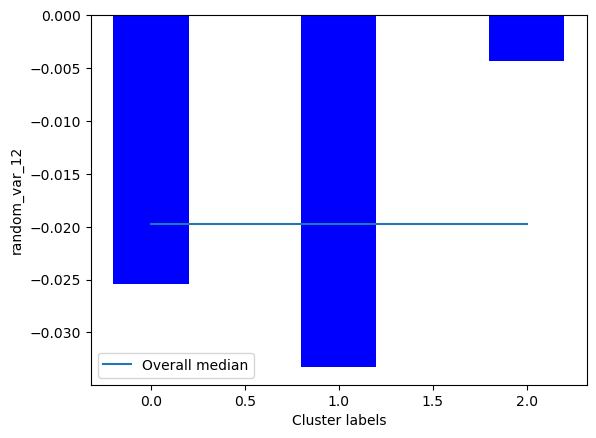

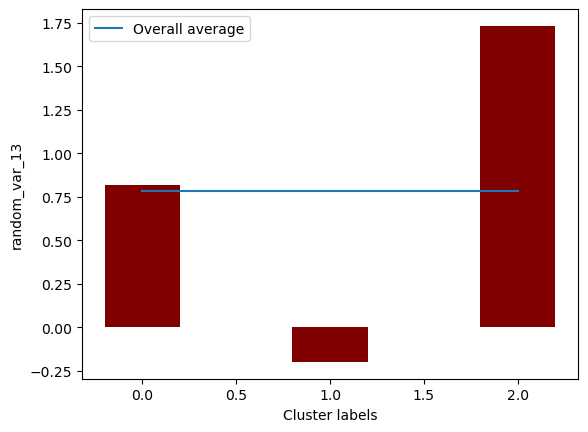

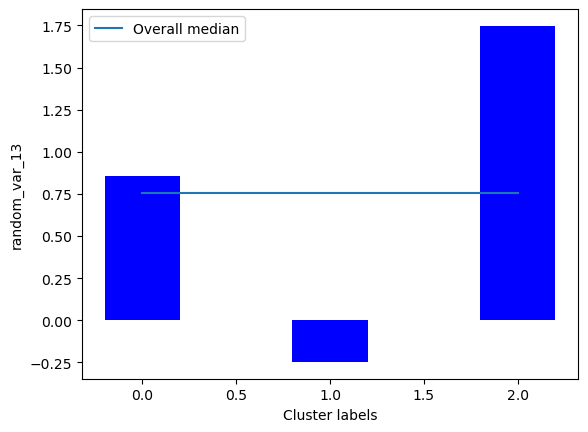

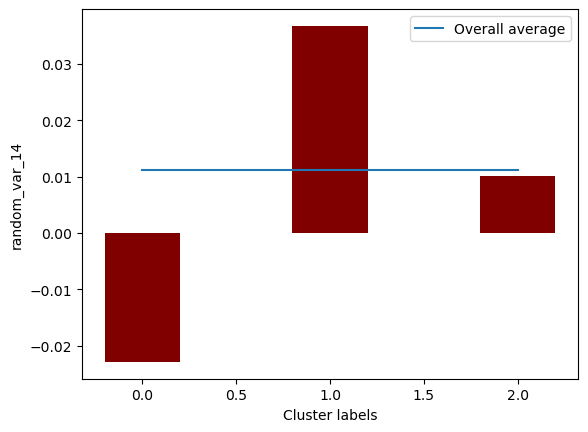

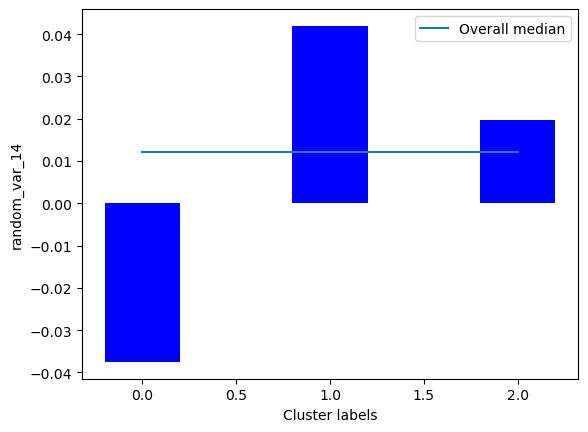

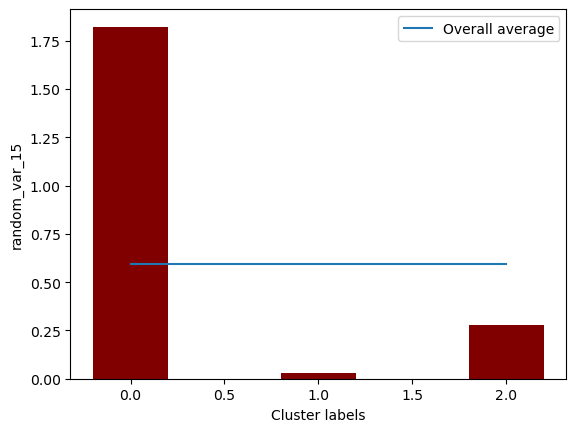

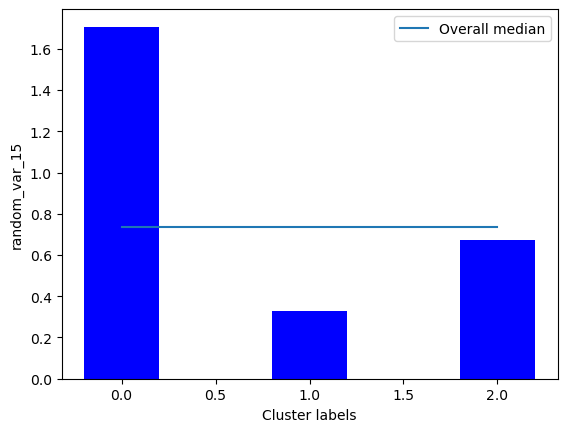

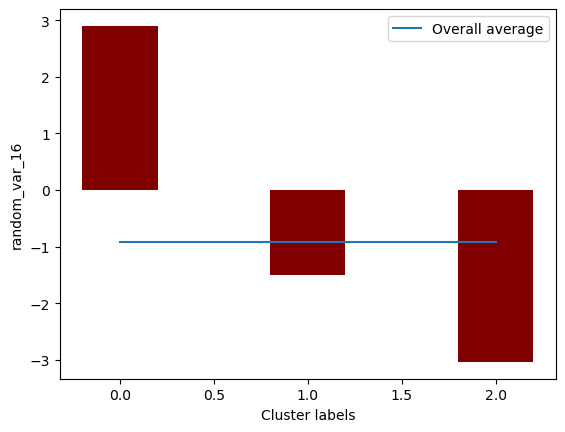

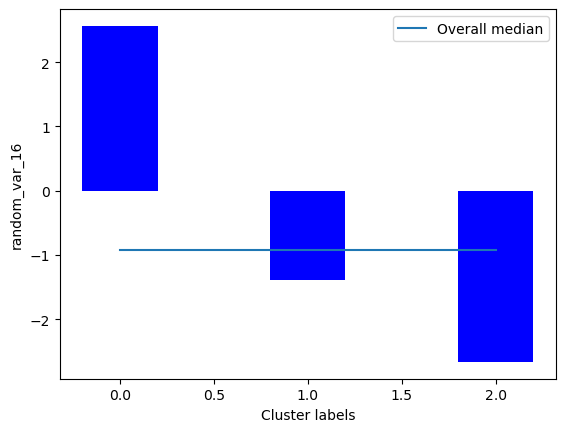

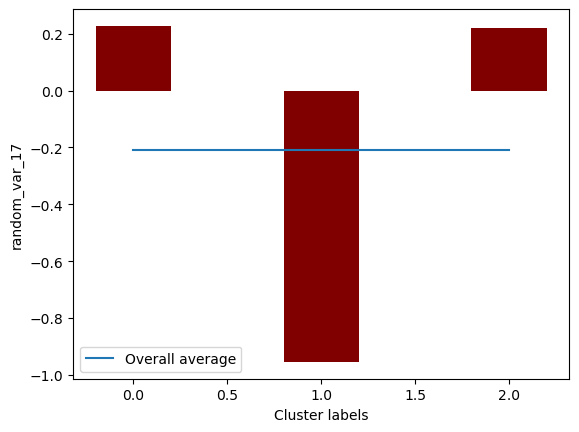

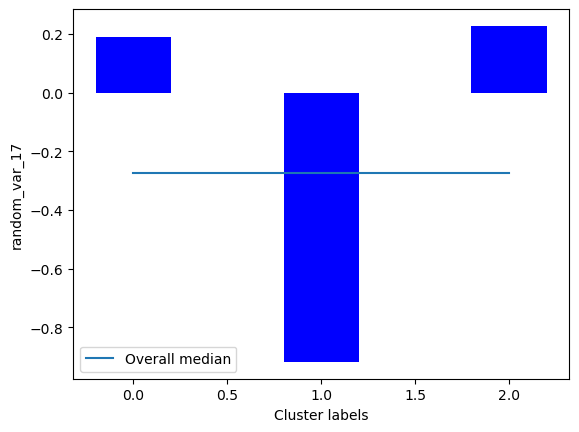

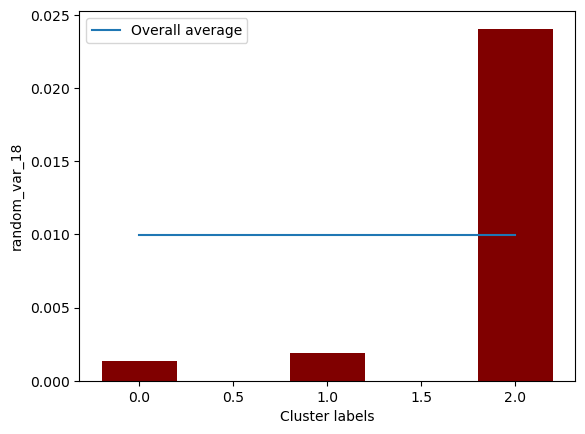

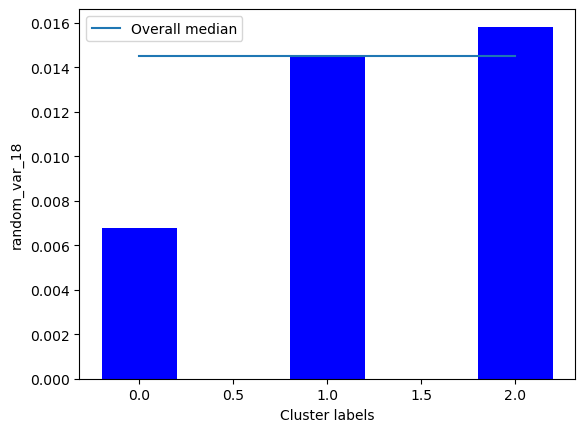

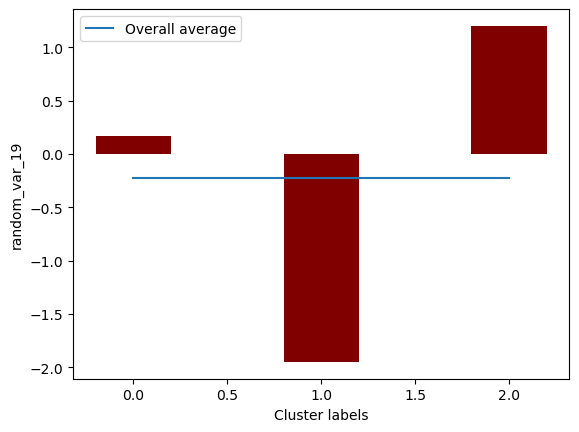

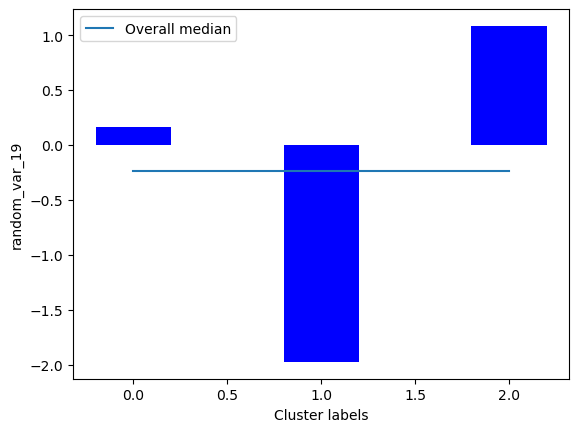

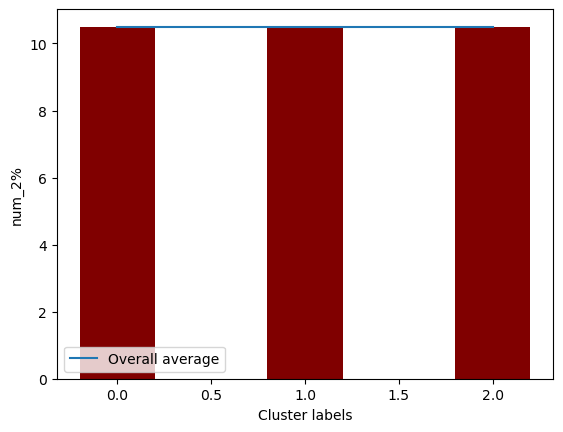

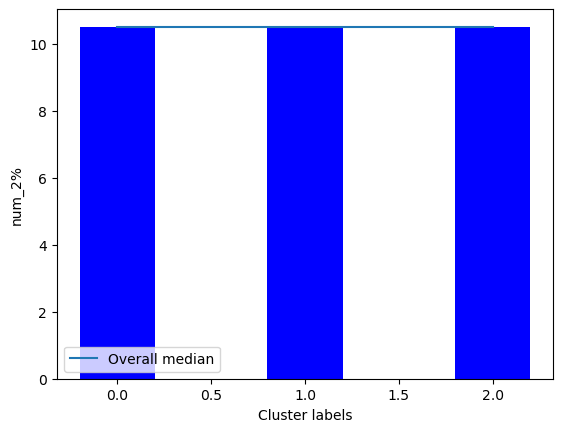

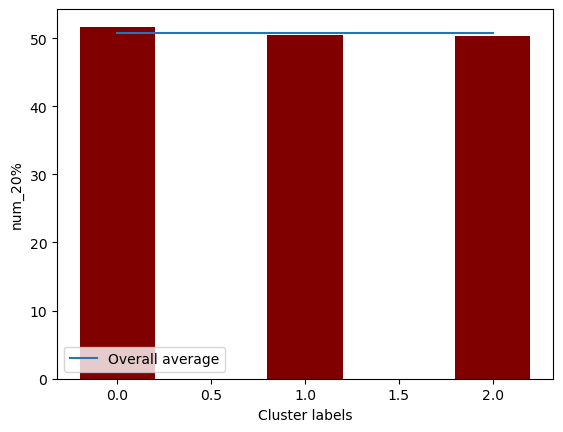

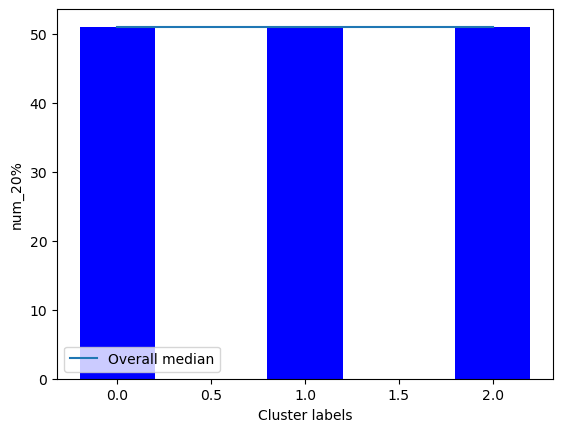

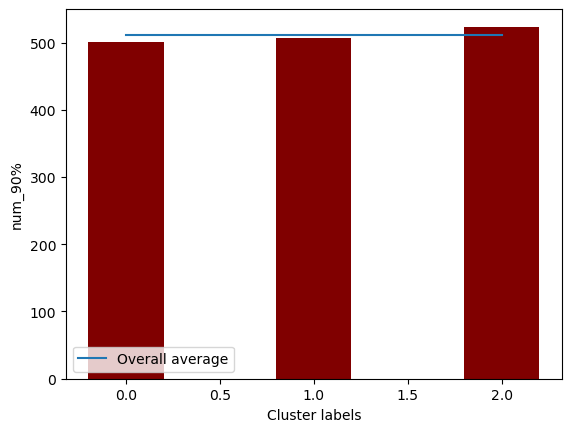

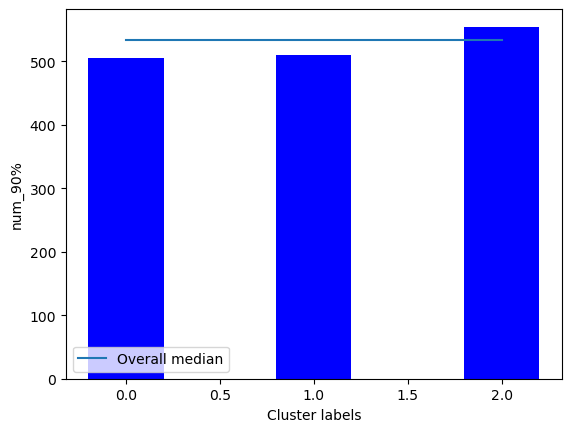

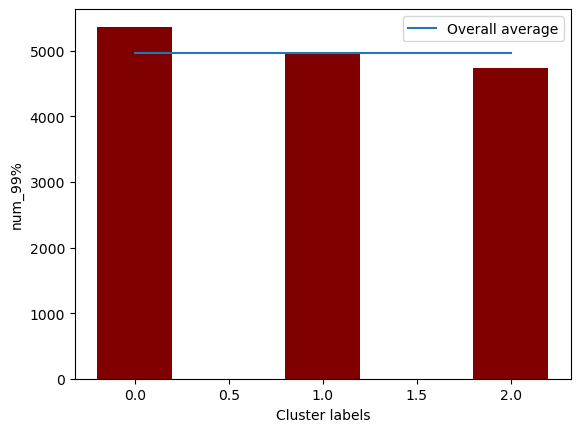

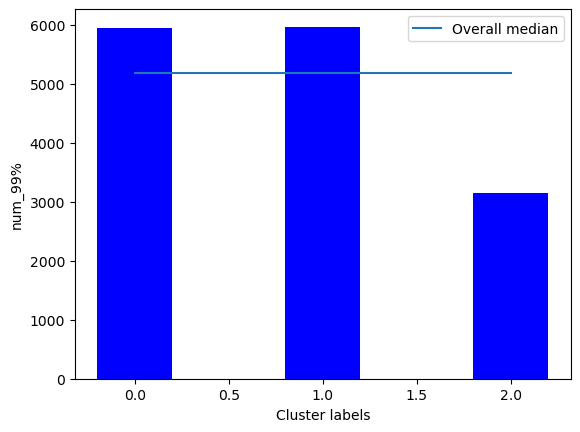

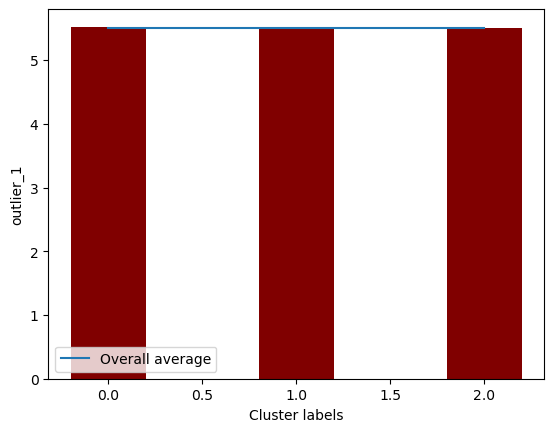

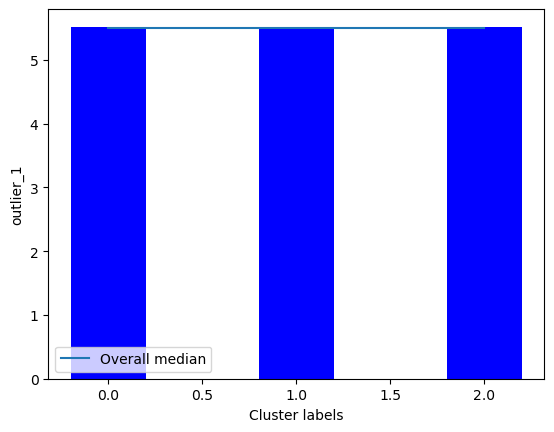

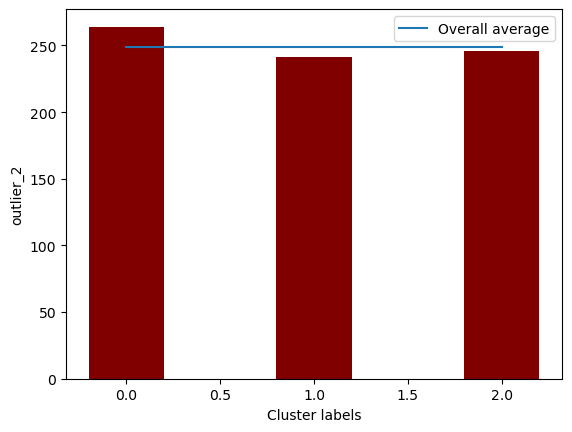

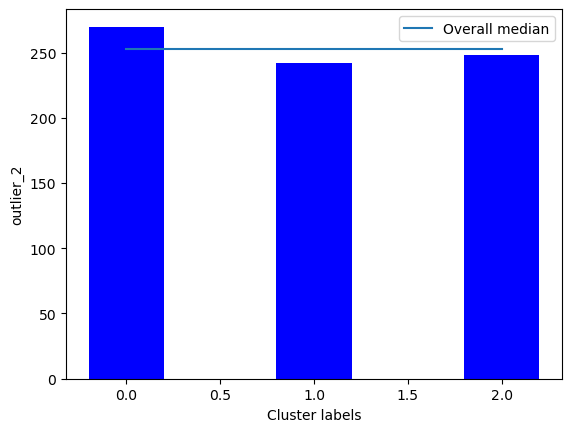

cluster_labels,Attribute,0,1,2,Baseline,0_baseline_diff,1_baseline_diff,2_baseline_diff
0,random_var_0,-0.03,-0.02,0.03,-0.01,424.33%,322.03%,-618.09%
1,random_var_1,-0.15,-1.37,-1.25,-1.01,-84.88%,35.78%,24.66%
2,random_var_2,0.01,-0.02,0.02,0.01,132.33%,-385.03%,286.80%
3,random_var_3,-1.77,1.53,-0.16,0.04,-5035.95%,4160.54%,-549.76%
4,random_var_4,0.04,0.03,0.01,0.02,73.54%,16.66%,-68.45%
5,random_var_5,1.29,-0.09,-0.74,0.03,4162.71%,-412.04%,-2535.78%
6,random_var_6,0.34,-1.22,0.50,-0.17,-296.78%,608.55%,-391.33%
7,random_var_7,-1.16,-2.25,2.66,-0.14,705.29%,1459.49%,-1940.33%
8,random_var_8,0.15,0.06,-1.73,-0.58,-125.79%,-111.14%,198.71%
9,random_var_9,-1.57,1.04,0.17,0.03,-5161.57%,3245.94%,442.50%


numeric_summary_statistics took 10.18 seconds


In [60]:
pro.numeric_summary_statistics(
    table_name = data_cluster, 
    variable_list = [x for x in numeric_variables_list_profiling if x not in [weight_variable_name_solution]], 
    cluster_variable_name = 'cluster_labels', 
    weight_variable_name = weight_variable_name_solution,
    data_path = data_path
    )